In [1]:
import os
import re
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import collections

In [69]:
#import dataset from stata files
def read_stata_to_dataframe(filename):
    #print(filename)
    f1 = pd.read_stata(filename)[['location_id','partner_id','product_id']]
    return f1

def read_in(path):
    files = os.listdir(path)
    all_dfs = []
    #print(files)
    for i in files:
        each_df = read_stata_to_dataframe(path+i)
        all_dfs.append(each_df)         
    return all_dfs

#all_dfs: a list of dataframes for each years
#full_dfs: a merged dataframe of all_dfs
all_dfs = read_in('C:/Users/luoyu/Desktop/USCISI/ATLAS/International Trade Data (HS,92) 4-digits/')
for i in range(len(all_dfs)):
    all_dfs[i]['year'] = 1995+i
full_df = pd.concat(all_dfs, ignore_index=True)

In [8]:
#intersect to find consistent countries
locations = pd.read_stata(r'C:\Users\luoyu\Desktop\USCISI\ATLAS\locations.dta')
all_sets = []
for df in all_dfs:
    country_set = set(df.location_id)
    all_sets.append(country_set)
intersect_countries = set.intersection(*all_sets)

for df in all_dfs:
    country_set = set(df.partner_id)
    all_sets.append(country_set)
intersect_countries_partner = set.intersection(*all_sets)

#find inconsistent countries to exclude from country list
all_locations = range(1,250)
excluded_location_ix = [i for i in all_locations if i not in list(intersect_countries)]
excluded_location = locations.iloc[excluded_location_ix]

In [377]:
#filtered out inconsistent countries
filtered_df = full_df[full_df['location_id'].isin(list(intersect_countries))]
filtered_df = filtered_df[filtered_df['partner_id'].isin(list(intersect_countries_partner))]

In [46]:
#backup filtered data
filtered_df.to_stata('HS_countries_filtered.dta')

In [2]:
filtered_df = pd.read_stata(r'C:\Users\luoyu\Desktop\USCISI\ATLAS\HS_countries_filtered.dta')

# construct graph

In [76]:
# construct graphs
##construct graph given the product_ids and year
###product: dataframe of input product of all years
###year: a certain year
###G: the union graph for all products in list
def construct_graph(product, year):
    #select product trade info of certain year
    year_product = product[product['year']==year][['location_id','partner_id']]
    G = nx.from_pandas_edgelist(year_product,'location_id','partner_id').to_undirected()
    return G

##get the graph statistics
###specific details of each function used can be found networkx documentation
def get_graph_stats(G):
    num_nodes = G.number_of_nodes()
    G_deg = nx.degree_histogram(G)
    G_deg_sum = [a * b for a, b in zip(G_deg, range(0, len(G_deg)))]
    ave_degree = sum(G_deg_sum) / G.number_of_nodes()
    avg_coe = nx.average_clustering(G)
    triangles = nx.triangles(G)
    density = nx.density(G)
    total_triangles = sum(triangles.values())
    diameter = nx.diameter(G)
    #print(ave_degree)
    return num_nodes, ave_degree, avg_coe,density,total_triangles,diameter

##get graph statistics for all years
###product_id: a list of product_ids
def construct_graph_all_years(product_id):
    #select product trades from filtered_df based on the list of product_id
    product = filtered_df[filtered_df['product_id'].isin(product_id)]
    product = product.drop_duplicates(subset=['location_id', 'partner_id','year'], keep='last')
    num_nodes_list, ave_degree_list,avg_coe_list,density_list,total_triangles_list,diameter_list = [],[],[],[],[],[]
    #loop through years to append graph statistics to each stats list 
    for i in years:
        G = construct_graph(product,i)
        num_nodes, ave_degree,avg_coe,density,total_triangles,diameter = get_graph_stats(G)
        num_nodes_list.append(num_nodes)
        ave_degree_list.append(ave_degree)
        avg_coe_list.append(avg_coe)
        density_list.append(density)
        total_triangles_list.append(total_triangles)
        diameter_list.append(diameter)
        #print(ave_degree_list)
    return [num_nodes_list, ave_degree_list,avg_coe_list,density_list,total_triangles_list,diameter_list]

##plot a list of plot for 'Average Degree','Average Coefficient','Density','Total Number of Triangles' given the product_ids and year
def plotgraph(graph_stats_list,product_id,product_name):
    fig = plt.figure(figsize=(4,20))
    #fig.suptitle('Graph Attributes for Section ' + product_name + ' (Number of 4-digit products: ' + str(len(product_id)) +')', fontsize=20)
    a,b,c=4,1,1
    for graph_stats,stats_type in zip(graph_stats_list[1:5],stats_type_list[1:5]):
        plt.subplot(a, b, c)
        plt.plot(years,graph_stats)
        #plt.title(stats_type + ' by Year for ' + product_name, fontsize=10)
        plt.title(product_name, fontsize=10)
        plt.xlabel('years', fontsize=10)
        plt.ylabel(stats_type, fontsize=10)
        c=c+1
    plt.show()

In [4]:
#for ploting a single graph of one graph statitics, only used for debug and testing
def plotgraph(graph_stats_list,product_id,product_name):
    fig = plt.figure(figsize=(4,4))
    #fig.suptitle('Graph Attributes for Section ' + product_name + ' (Number of 4-digit products: ' + str(len(product_id)) +')', fontsize=20)
    a,b,c=1,1,1
    #print(graph_stats)
    plt.subplot(a, b, c)
    plt.plot(years,graph_stats_list[0])

    plt.title(product_name, fontsize=10)
    plt.xlabel('years', fontsize=10)
    plt.ylabel(stats_type_list[0], fontsize=10)

    plt.show()

In [46]:
#years and graph statistics' names
years = range(1995,2018)
stats_type_list = ['Number of Countries','Average Degree','Average Coefficient','Density','Total Number of Triangles','Diameter']

# Product hierarchical relations join and sampling

In [77]:
#group by product_id and generate frequency for each product
prudcut_edge_count = filtered_df.groupby(['product_id']).size().reset_index(name='counts').sort_values(by='counts')
sample_product = prudcut_edge_count

In [78]:
#load meta description file from hs_product.dta
product_info = pd.read_stata(r'C:\Users\luoyu\Desktop\USCISI\ATLAS\Classifications Data\hs_product.dta')
#get 2-digit level names and hierarchical relations
product_2digit = product_info[product_info['level']=='2digit'][['product_id','hs_product_name_short_en','parent_id']].rename(columns={"hs_product_name_short_en": "2digit_name", "parent_id": "2digit_parent_id"})
#get section names and hierarchical relations
product_section = product_info[product_info['level']=='section'][['product_id','hs_product_name_short_en']].rename(columns={"hs_product_name_short_en": "section_name"})

In [79]:
#join to link hierarchical relations from section to 2-digit to 4-digit level
sample_product_info = sample_product.set_index('product_id').join(product_info.set_index('product_id')).reset_index()
sample_product_info = sample_product_info.set_index('parent_id').join(product_2digit.set_index('product_id')).reset_index()
sample_product_info = sample_product_info.set_index('2digit_parent_id').join(product_section.set_index('product_id')).reset_index()
sample_product_info = sample_product_info.rename(columns={"level_0": "product_id_section","index": "product_id_2digit"}) 

In [71]:
sample_product_info

,product_id_section,product_id_2digit,product_id,counts,hs_product_code,hs_product_name_short_en,level,2digit_name,section_name
0,0.0,149.0,1226,4786,5001,Silkworm cocoons,4digit,Silk,Textiles
1,0.0,149.0,1228,9920,5003,Silk waste,4digit,Silk,Textiles
2,0.0,149.0,1227,9934,5002,Raw silk,4digit,Silk,Textiles
3,0.0,149.0,1230,11456,5005,Yarn from silk waste,4digit,Silk,Textiles
4,0.0,149.0,1231,16018,5006,"Silk yarn, for retail sale",4digit,Silk,Textiles
...,...,...,...,...,...,...,...,...,...
1238,8.0,183.0,1720,259416,8517,Telephones,4digit,Electrical machinery and equipment,Electronics
1239,8.0,183.0,1707,263070,8504,Electrical transformers,4digit,Electrical machinery and equipment,Electronics
1240,8.0,183.0,1739,273796,8536,Electrical apparatus for < 1k volts,4digit,Electrical machinery and equipment,Electronics
1241,9.0,196.0,1892,864,XXXX,Trade data discrepancies,4digit,Other,Other


In [80]:
section_name_list = list(product_section['section_name'])

In [81]:
#select a specific section based on section id
sample_product_info_section = sample_product_info[sample_product_info['product_id_section']==1]

## Figure 1-4

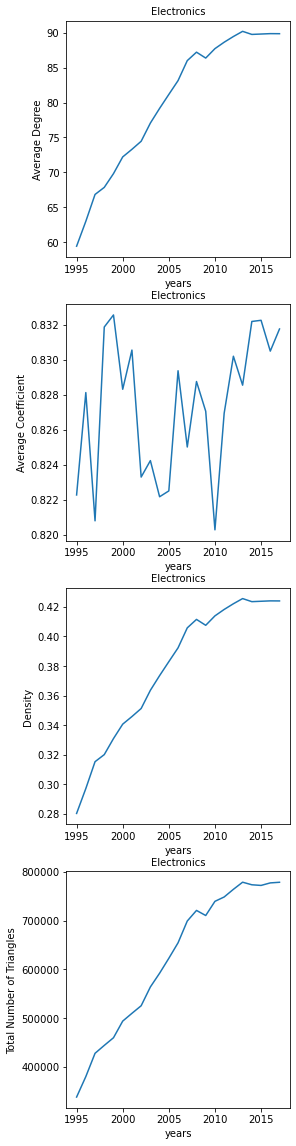

In [82]:
#compute graph stats for a single set of union products
sample_product_info_section = sample_product_info[sample_product_info['product_id_section']==8] #edit section id
product_id_list = list(sample_product_info_section['product_id'])
graph_stats_list = construct_graph_all_years(product_id_list)
plotgraph(graph_stats_list, product_id_list,'Electronics') ##edit section name


## Figure 7: Degree distributions 

In [ ]:
sample_product_info_section = sample_product_info[sample_product_info['product_id_section']==1]#edit section id

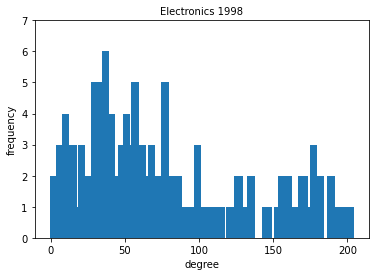

In [72]:
#For ploting degree distribution
###product_id: a list of product_ids
###deg: unziped pair of number of degree
###cnt: unziped pair of degree frequency
def degreeDist(product_id, year):
    product = filtered_df[filtered_df['product_id'].isin(product_id)]
    product = product.drop_duplicates(subset=['location_id', 'partner_id','year'], keep='last')
    G = construct_graph(product,year)
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())

    return deg,cnt

#plot degree distribution
product_id_list = list(sample_product_info_section['product_id'])
deg,cnt = degreeDist(product_id_list, 1998) ##edit year
plt.bar(deg, cnt, 5)
plt.title('Electronics 1998', fontsize=10) ##edit section name and year
plt.xlabel('degree', fontsize=10)
plt.ylabel('frequency', fontsize=10)
plt.ylim([0, 7])
plt.show()

## Table 2: Diameter statistic 

In [ ]:
for i in range(9):
    sample_product_info_section = sample_product_info[sample_product_info['product_id_section']==i]
    product_id_list = list(sample_product_info_section['product_id'])
    graph_stats_list = construct_graph_all_years(product_id_list)
    diameter_list = graph_stats_list[5]
    print(diameter_list)
    mean = sum(diameter_list)/len(diameter_list)
    variance = sum([((x - mean) ** 2) for x in diameter_list]) / len(diameter_list)
    res = variance ** 0.5
    print(section_name_list[i], mean, res, min(diameter_list), max(diameter_list))
    #plotgraph(graph_stats_list, product_id_list,section_name_list[i])

## Table 3:Correlation

In [292]:
gdp = pd.read_csv(r'C:\Users\luoyu\Desktop\USCISI\ATLAS\gross-domestic-product.csv')

Text(0, 0.5, 'GDP (USD)')

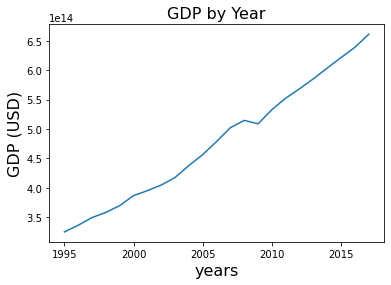

In [317]:
#load gdp for comparision
gdp_by_year = gdp.groupby(by='Year').sum()
gdp_by_year = gdp_by_year[gdp_by_year.index >= 1990 ]
gdp_by_year = gdp_by_year[5:28]
plt.plot(gdp_by_year)
plt.title('GDP by Year',fontsize=16)
plt.xlabel('years', fontsize=16)
plt.ylabel('GDP (USD)', fontsize=16)


In [304]:
num_nodes_list, ave_degree_list,avg_coe_list,density_list,total_triangles_list,diameter_list = construct_graph_all_years(list(sample_product_info_section['product_id']))

In [402]:
#calculate correlation
for i in range(5):
    i+5
    sample_product_info_section = sample_product_info[sample_product_info['product_id_section']==i]
    num_nodes_list, ave_degree_list,avg_coe_list,density_list,total_triangles_list,diameter_list = construct_graph_all_years(list(sample_product_info_section['product_id']))
    gdp_by_year['ave_degree']=ave_degree_list
    gdp_by_year['density'] = density_list
    gdp_by_year['total_triangles'] = total_triangles_list
    gdp_by_year['diameter'] = diameter_list
    gdp_by_year['avg_coe'] = avg_coe_list
    gdp_by_year['num_nodes'] = num_nodes_list
    print(i, gdp_by_year.corr(method='pearson').round(decimals=3).head(1))

0                          GDP (constant 2010 US$)  ave_degree  density  \
GDP (constant 2010 US$)                      1.0       0.918    0.917   

                         total_triangles  diameter  avg_coe  num_nodes  
GDP (constant 2010 US$)            0.945       NaN    0.607      0.376  
1                          GDP (constant 2010 US$)  ave_degree  density  \
GDP (constant 2010 US$)                      1.0       0.938    0.937   

                         total_triangles  diameter  avg_coe  num_nodes  
GDP (constant 2010 US$)             0.96    -0.114    0.888      0.113  
2                          GDP (constant 2010 US$)  ave_degree  density  \
GDP (constant 2010 US$)                      1.0       0.925    0.925   

                         total_triangles  diameter  avg_coe  num_nodes  
GDP (constant 2010 US$)            0.946       NaN   -0.147      0.217  
3                          GDP (constant 2010 US$)  ave_degree  density  \
GDP (constant 2010 US$)                 

In [399]:
print(gdp_by_year.corr(method='pearson').round(decimals=3).head(1))

                         GDP (constant 2010 US$)  ave_degree  density  \
GDP (constant 2010 US$)                      1.0       0.934    0.936   

                         total_triangles  diameter  avg_coe  num_nodes  
GDP (constant 2010 US$)            0.956    -0.321   -0.156      0.439  


In [334]:
gdp_by_year

,GDP (constant 2010 US$),ave_degree,density,total_triangles
Year,,,,
1995,3.250616e+14,42.622010,0.204914,183177
1996,3.364843e+14,44.961905,0.215129,203139
1997,3.495362e+14,48.579710,0.235824,228033
1998,3.582834e+14,48.609524,0.232581,234366
1999,3.698439e+14,50.191388,0.241305,247038
2000,3.868146e+14,51.107981,0.241075,261651
2001,3.952085e+14,52.909953,0.251952,274230
2002,4.047911e+14,53.801887,0.254985,284616
2003,4.175500e+14,56.009390,0.264195,308490
